In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
!pip install "tensorflow_hub>=0.6.0"
import tensorflow_hub as hub

     |████████████████████████████████| 103 kB 3.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
# helpers

def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

In [7]:
model = tf.keras.Sequential([
                             hub.KerasLayer(name='inception_v1', 
                                            handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4', 
                                            trainable=False),
                             ])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    multiple                  6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [8]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

16384/10484 [==============================================] - 0s 0us/step


In [9]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

811008/802859 [==============================] - 0s 0us/step


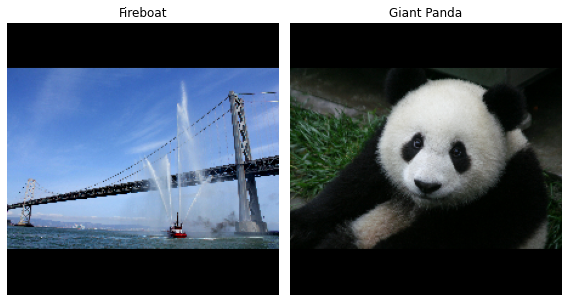

In [10]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

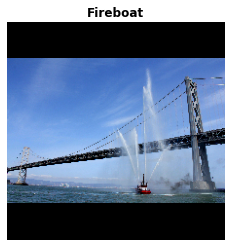

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


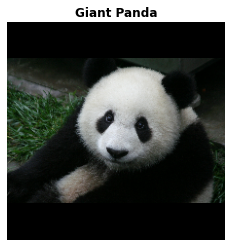

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [11]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()

    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

## Calculate Integrated Gradients

In [9]:
def f(x):
    """A simplified model function."""
    return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
    """A straight line path."""
    return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

In [10]:
y

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0. , 0.2, 0.4, 0.6, 0.8, 0.8], dtype=float32)>

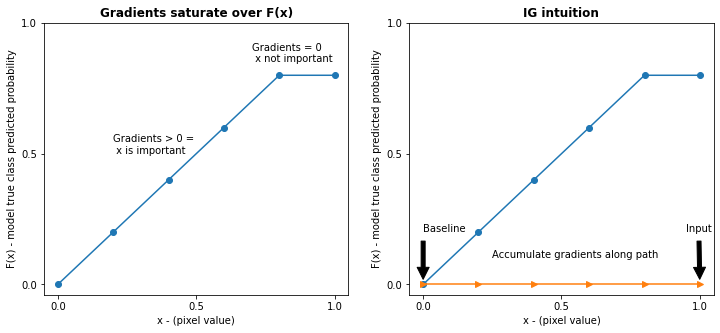

In [11]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

### Create baseline image

In [12]:
baseline = tf.zeros(shape=(224,224,3))

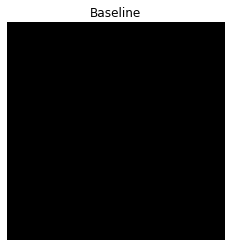

In [13]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Alphas for interpolation

In [14]:
m_steps=20
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [15]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

In [16]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

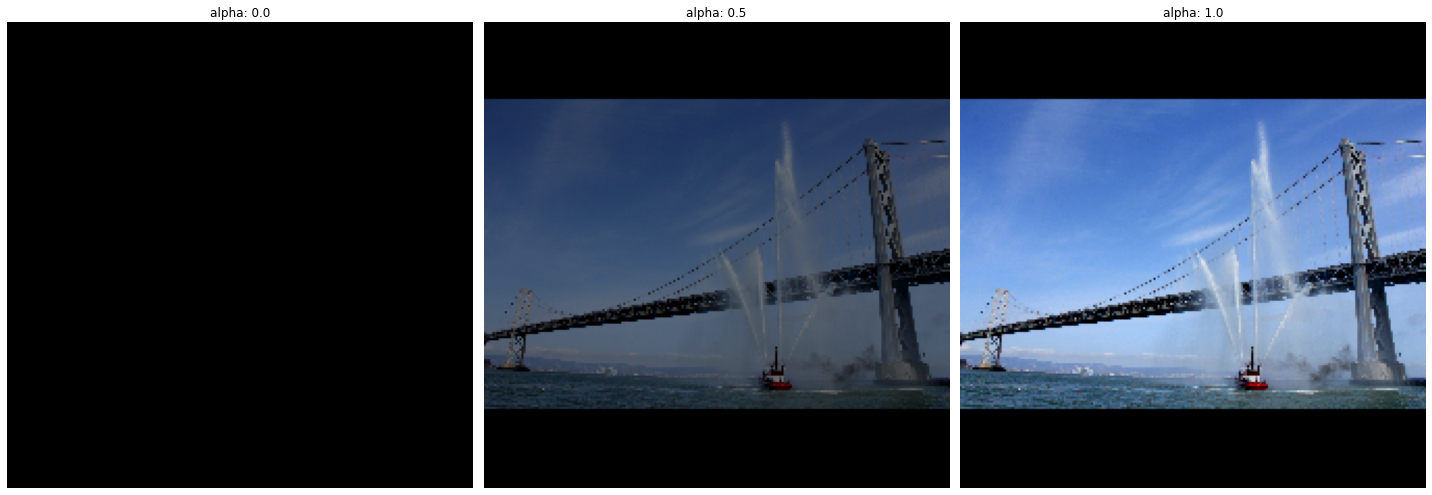

In [17]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

### Compute Gradient

In [18]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
    g.watch(x)
    y = x * x
dy_dx = g.gradient(y, x)

In [19]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [18]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [19]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

In [20]:
path_gradients.shape

TensorShape([21, 224, 224, 3])

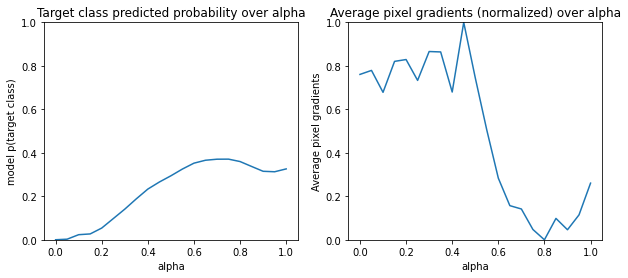

In [21]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

### Accumulate gradients (integral approximation)

In [22]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [23]:

tf.math.reduce_mean(path_gradients, axis=0)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[-4.9827062e-04, -2.6744953e-04,  7.6317589e-04],
        [ 1.6910366e-03,  2.0006963e-05,  1.0863794e-03],
        [ 6.7615495e-03,  2.9515023e-03,  2.5871859e-03],
        ...,
        [ 4.0900675e-03,  5.7877302e-03,  4.3910467e-03],
        [-7.9389652e-03, -6.2903054e-03, -3.8510386e-03],
        [-5.9492998e-03, -5.9222123e-03, -3.6987411e-03]],

       [[-3.3702482e-03, -5.5644410e-03, -2.1287729e-03],
        [ 4.1031875e-03,  1.0079066e-03,  5.5359942e-05],
        [ 1.3368081e-02,  8.8811992e-03,  2.3484316e-03],
        ...,
        [ 2.4965459e-03,  8.5553527e-04,  1.9076297e-03],
        [-3.9545055e-03, -3.4667035e-03, -5.6039332e-04],
        [-4.0373332e-03, -3.2127432e-03, -6.6452875e-04]],

       [[-3.4989726e-03, -4.9031032e-03, -2.1345280e-03],
        [-1.4724688e-03, -4.3325033e-03, -3.1856894e-03],
        [-6.1300029e-03, -1.1642254e-02, -1.3099465e-02],
        ...,
        [-3.0502691e-03, -7.0859

In [24]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=20,
                         batch_size=32):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                           target_class_idx=target_class_idx)

        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()

    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [25]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=20)

In [26]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

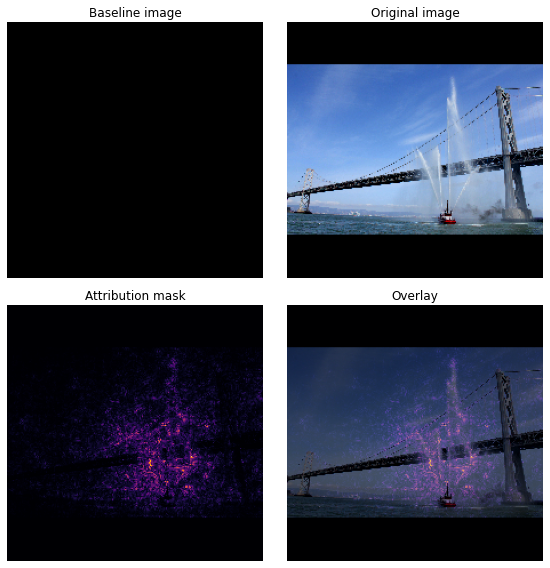

In [27]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=20,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)